# Trying pre-trained model on (sort of) real life German Speed Limit Signs

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Installation of required libs Scikit Learn, TensorFlow, and Keras

In [3]:
!conda install --name root scikit-learn -y

Fetching package metadata .......
Solving package specifications: ..........

Package plan for installation in environment /home/nbcommon/anaconda3_410:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-env-2.6.0            |                0          502 B

The following packages will be UPDATED:

    conda:     4.2.13-py35_0 conda-forge --> 4.3.16-py35_0

The following packages will be SUPERCEDED by a higher-priority channel:

    conda-env: 2.6.0-0       conda-forge --> 2.6.0-0      

Pruning fetched packages from the cache ...
Fetching packages ...
conda-env-2.6. 100% |################################| Time: 0:00:00 742.17 kB/s
Extracting packages ...
[      COMPLETE      ]|###################################################| 100%
Unlinking packages ...
[      COMPLETE      ]|###################################################| 100%
Linking packages ...
[      COMPLETE      ]|##

In [4]:
from distutils.version import StrictVersion

In [5]:
import sklearn

# should at least be 0.18
assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

sklearn.__version__

'0.18.1'

In [6]:
!conda install --name root -c conda-forge tensorflow -y

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/nbcommon/anaconda3_410:

The following packages will be SUPERSEDED by a higher-priority channel:

    conda:     4.3.16-py35_0 --> 4.2.13-py35_0 conda-forge
    conda-env: 2.6.0-0       --> 2.6.0-0       conda-forge

conda-env-2.6. 100% |################################| Time: 0:00:00   1.37 MB/s


In [7]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# should at least be 1.0
assert StrictVersion(tf.__version__) >= StrictVersion('1.0.0')

tf.__version__

'1.0.0'

In [8]:
!pip install keras

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
import keras as keras

# should at least be 1.2 and use TensorFlow backend
assert StrictVersion(keras.__version__) >= StrictVersion('1.2.2')

keras.__version__

Using TensorFlow backend.


'2.0.3'

## Download data

In [10]:
# https://notebooks.azure.com/faq#service_restrictions
# https://notebooks.azure.com/faq#upload_data
# https://notebooks.azure.com/n/xwZx1vmIroU/notebooks/Getting%20to%20your%20Data%20in%20Azure%20Notebooks.ipynb

In [11]:
!curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/real-world.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1203k  100 1203k    0     0  2767k      0 --:--:-- --:--:-- --:--:-- 2767k


In [12]:
!rm -r real-world

rm: cannot remove 'real-world': No such file or directory


In [13]:
# https://docs.python.org/3/library/zipfile.html
from zipfile import ZipFile
zip = ZipFile(r'real-world.zip')
zip.extractall('.')

In [14]:
!ls -l real-world

total 24
drwxr-xr-x 2 nbuser nbuser 4096 Apr 27 10:07 0
drwxr-xr-x 2 nbuser nbuser 4096 Apr 27 10:07 1
drwxr-xr-x 2 nbuser nbuser 4096 Apr 27 10:07 2
drwxr-xr-x 2 nbuser nbuser 4096 Apr 27 10:07 3
drwxr-xr-x 2 nbuser nbuser 4096 Apr 27 10:07 4
drwxr-xr-x 2 nbuser nbuser 4096 Apr 27 10:07 5


In [15]:
import os
import skimage.data
import skimage.transform

def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    all_file_names = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
            all_file_names.append(f)
    # Resize images
    images64 = [skimage.transform.resize(image, (64, 64))
                for image in images]
    return images64, labels, all_file_names

In [16]:
# Load datasets.
ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "real-world")

images, labels, file_names = load_data(data_dir)

In [17]:
len(images)

15

In [18]:
labels

[1, 1, 1, 5, 5, 0, 0, 0, 4, 4, 2, 2, 2, 3, 3]

In [19]:
file_names

['./real-world/1/50-berlin.jpg',
 './real-world/1/50-berlin-detail.jpg',
 './real-world/1/50-fence.jpg',
 './real-world/5/120-motorway.jpg',
 './real-world/5/120-motorway-detail.jpg',
 './real-world/0/30-slim.jpg',
 './real-world/0/30-berln-detail.jpg',
 './real-world/0/30-berln.jpg',
 './real-world/4/100-sky-cutoff-detail.jpg',
 './real-world/4/100-sky-cutoff.jpg',
 './real-world/2/70-house.jpg',
 './real-world/2/70-house-detail.jpg',
 './real-world/2/70-tree.jpg',
 './real-world/3/80-scenery.jpg',
 './real-world/3/80-scenery-detail.jpg']

In [20]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    plt.figure(figsize=(15, 15))
    i = 0
    for label in labels:
        # Pick the first image for each label.
        image = images[i]
        plt.subplot(4, 4, i + 1)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("{0}".format(label))
        i += 1
        plt.imshow(image)
    plt.show()

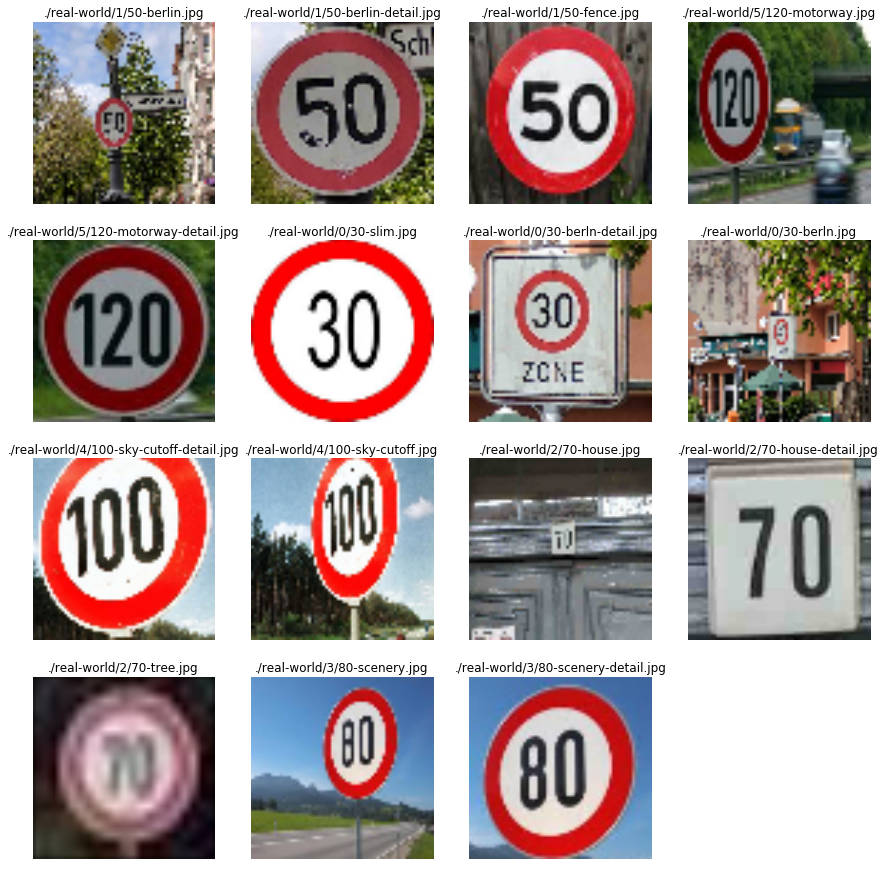

In [21]:
display_images_and_labels(images, file_names)

## Load model

In [22]:
from keras.models import load_model

In [32]:
!curl -O https://transfer.sh/xjzxH/conv-vgg.h5
# !curl -O https://transfer.sh/tntFr/conv-vgg.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 33.0M  100 33.0M    0     0  11.1M      0  0:00:02  0:00:02 --:--:-- 11.1M


In [ ]:
# !curl -O https://transfer.sh/C36DS/conv-inception.h5

In [ ]:
!curl -O https://transfer.sh/ldleM/conv-residual.h5

In [24]:
!ls -l

total 36900
drwxr-xr-x 3 nbuser nbuser     4096 Apr 27 08:45 __MACOSX
lrwxrwxrwx 1 nbuser nbuser       28 Apr 26 10:26 anaconda2_410 -> /home/nbcommon/anaconda2_410
lrwxrwxrwx 1 nbuser nbuser       28 Apr 26 10:26 anaconda3_410 -> /home/nbcommon/anaconda3_410
-rw-r--r-- 1 nbuser nbuser 34676888 Apr 27 10:07 conv-vgg.h5
drwxr-xr-x 2 nbuser nbuser     4096 Apr 27 10:04 models
drwxr-xr-x 8 nbuser nbuser     4096 Apr 27 10:07 real-world
-rw-r--r-- 1 nbuser nbuser  1232773 Apr 27 10:06 real-world.zip
drwxr-xr-x 8 nbuser nbuser     4096 Apr 27 08:45 speed-limit-signs
-rw-r--r-- 1 nbuser nbuser  1853545 Apr 27 09:36 speed-limit-signs.zip


In [33]:
model = load_model('conv-vgg.h5')

In [ ]:
# model = load_model('conv-inception.h5')

In [ ]:
# model is tiny, no final fc layer
# model = load_model('conv-residual.h5')

In [26]:
import skimage.transform
def predict_single(image):
    # normalize
    X_sample = np.array([image])
    prediction = model.predict(X_sample)
    predicted_category = np.argmax(prediction, axis=1)
    return predicted_category, prediction

In [27]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(6, 3,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

## Make Predictions

In [34]:
X_sample = np.array(images)
prediction = model.predict(X_sample)
prediction

array([[  1.80286079e-08,   3.94595965e-08,   7.85503662e-09,
          7.93958410e-09,   1.56235311e-03,   9.98437583e-01],
       [  7.83617735e-01,   2.15879723e-01,   4.06442632e-06,
          2.46531679e-04,   2.60209942e-09,   2.51963647e-04],
       [  1.14844683e-19,   1.00000000e+00,   2.26019435e-26,
          8.85847267e-21,   0.00000000e+00,   1.77812874e-30],
       [  9.93411362e-01,   6.21453091e-06,   5.06358128e-03,
          8.69666223e-08,   1.44965178e-03,   6.90841989e-05],
       [  1.25227857e-17,   1.21743005e-20,   1.54665686e-04,
          6.07634082e-12,   2.16241941e-13,   9.99845266e-01],
       [  9.97394443e-01,   5.66829357e-08,   1.12941471e-17,
          2.60551879e-03,   1.17817803e-19,   3.71152137e-11],
       [  2.53063859e-03,   5.97177207e-01,   3.78354599e-07,
          9.45383874e-07,   5.97306971e-05,   4.00231123e-01],
       [  3.24750389e-03,   4.86193086e-09,   3.77997814e-04,
          6.51514664e-09,   9.17891636e-02,   9.04585361e-01],


In [35]:
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([5, 0, 1, 0, 5, 0, 1, 5, 5, 5, 0, 2, 2, 0, 5])

In [36]:
ground_truth = np.array(labels)
ground_truth

array([1, 1, 1, 5, 5, 0, 0, 0, 4, 4, 2, 2, 2, 3, 3])

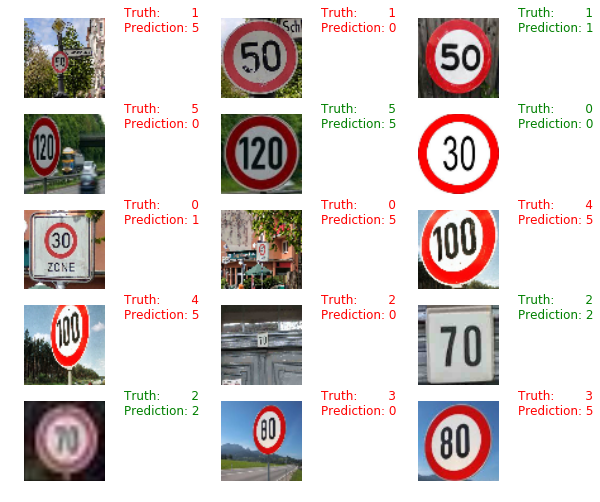

In [37]:
display_prediction(images, ground_truth, predicted_categories)

### VGG 5 correct, Inception 5 correct, Residual 7 correct, but different ones!

### Residual clearly the best, smallest model, best results

# Result
## Not so bad, especially as the non detail-images would have required translation invariance which was not at all in the training data

### But
* no translation invariance, signes have to be at center
* not robust against background
* false positives (70 is address sign, not traffic sign)
* not robust against unclear signes (50 looks like 30)
* 64x64 resolution too low for real world pictures (70 address sign, 50 sign Berlin)
* not robust against distortions (100, 80)
* why do different architectures give different accuracies on different classes of unknown data?
* even same architecture trained on same data give different results

### Next steps might be to
* artifically expand training set by applying transformations that match missing robustness
* introduce category 'no speed limit sign'
* translation invariance added in training material
* higher resolution (will result in longer training duration)
* try other architectures
